In [14]:
import os
import numpy as np
import scipy.io as spio
from scipy.stats import mode
import matplotlib.pyplot as plt
from lib import loadmat

ROOT = 'C:/Users/amcca/switchdrive/PhD/RR/'
DATA_TYPE = 'baseline'   # or baseline, end_ablation

# Import data
Import data from matlab and put into pandas data structure.

In [23]:
tau = 1
m = 2
coef = 0.1

# load in matlab data with appropriate parameters
filename = 'tau' + str(tau) + '_dim' + str(m) + '_coef' + str(coef) + '.mat'
mat = loadmat(ROOT + 'data/rr_indices/' + DATA_TYPE + '/' + filename)

# get each AF complexity index in column, each row corresponds to one patient
data_dict = mat['rr_indices_struct']
data_matrix = np.stack(list(data_dict.values()))
data_matrix = data_matrix.transpose()
feat_names = data_dict.keys()

# for clinical outcomes, SR=1, AR=0
y_clin = np.array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
# for procedural outcomes, LT=1, NT=0
y_proc=np.array([1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1])

X = data_matrix

## Statistical significance outcomes

The purpose of this notebook is to find which RR interval indices (features) can discriminate between patient subgroups based on procedural (LT vs NT) and clinical (AR vs SR) outcomes. Find which features are most discriminative across stratified, cross-validated folds, using one-way ANOVA test for statistically significant differences in means between groups.

In [24]:
from sklearn.model_selection import ShuffleSplit
from statsmodels.stats.diagnostic import lilliefors
from scipy.stats import ranksums
from sklearn.feature_selection import f_classif

# assign y based on outcome type
outcome_type = 'procedural'  # or 'clinical'
if outcome_type == 'clinical':
    y = y_clin
elif outcome_type == 'procedural':
    y = y_proc
else:
    print("Invalid outcome type.")
        
# create cross-validation folds
n_folds = 2
ss = ShuffleSplit(n_splits=n_folds, test_size=0.3, random_state=0)
fnorm = []
pnorm = []
Xpos = []
Xneg = []

plillie_pos = np.zeros((n_folds, len(feat_names)))
plillie_neg = np.zeros((n_folds, len(feat_names)))
prank = np.zeros((n_folds, len(feat_names)))

for i, (train, test) in enumerate(ss.split(X, y)):
    # enumerate over data folds and features
    for k, feat_name in enumerate(feat_names):
        # extract indices of each outcome group
        pos_idx = np.nonzero(y[train]==1)[0]
        neg_idx = np.nonzero(y[train]==0)[0]
        pos_idx_all = np.nonzero(y==1)[0]
        neg_idx_all = np.nonzero(y==0)[0]
        
        # use lilliefors statistic to determine whether data dist normally, if the 
        # returned p-value is lower than some threshold (e.g. 0.05) then reject null
        # hypothesis that data are normally distributed
        #ksstat_x, plillie_pos[i,k] = lilliefors(X[pos_idx,k], dist='norm')
        ksstat_x, plillie_neg[i,k] = lilliefors(X[neg_idx,k], dist='norm')
                      
        # calculate ranksum statistic
        statistic, prank[i,k] = ranksums(X[pos_idx,k], X[neg_idx,k])
        
    # get data values for all fold splits separated by group (for value reporting later?)
    Xpos.append(X[pos_idx_all,:])
    Xneg.append(X[neg_idx_all,:])
    
    # calculate anova p-values for all features in the fold, and append
    f_fold, p_fold = f_classif(X[train,:], y[train])
    fnorm.append(f_fold)
    pnorm.append(p_fold)
    
# calculate mean lilliefors/p-values across folds
fnorm = np.vstack(fnorm)
pnorm = np.vstack(pnorm)
Xpos = np.vstack(Xpos)
Xneg = np.vstack(Xneg)

mean_f = np.mean(fnorm, axis=0)
mean_plillie_pos = np.mean(plillie_pos, axis=0)
mean_plillie_neg = np.mean(plillie_neg, axis=0)
mean_pnorm = np.mean(pnorm, axis=0)
mean_prank = np.mean(prank, axis=0)

# calculate mean and std of positive and negative indexed data
mean_Xpos = np.mean(Xpos, axis=0)
mean_Xneg = np.mean(Xneg, axis=0)
std_Xpos = np.std(Xpos, axis=0)
std_Xneg = np.std(Xneg,axis=0)

## Feature statistical significance
Display results in a table: inspect mean/std of feature values in each group, along with p-value (either rank-sum or ANOVA).

In [25]:
from prettytable import PrettyTable

# assign y based on outcome type
if outcome_type == 'clinical':
    pos_idx_string = 'SR'
    neg_idx_string = 'AR'
    if DATA_TYPE == 'baseline':
        title_string = 'Clinical outcomes: baseline'
    elif DATA_TYPE == 'end ablation':
        title_string = 'Clinical outcomes: end ablation'
elif outcome_type == 'procedural':
    pos_idx_string = 'LT'
    neg_idx_string = 'NT'
    if DATA_TYPE == 'baseline':
        title_string = 'Procedural outcomes: baseline'
    elif DATA_TYPE == 'end ablation':
        title_string = 'Procedural outcomes: end ablation'
else:
    print("Invalid outcome type.")
    
t = PrettyTable(['Feature', pos_idx_string, neg_idx_string, 'p-lillie pos', 'p-lillie neg', 'p-anova', 'p-ranksum'])
#t = PrettyTable(['Feature', pos_idx_string, neg_idx_string, 'p-anova'])

for i, feat_name in enumerate(feat_names):
    t.add_row([feat_name, mean_Xpos[i], mean_Xneg[i], mean_plillie_pos[i], mean_plillie_neg[i], mean_pnorm[i], mean_prank[i]])
    
t.title = title_string
t.float_format = '0.3'
print(t)

+---------------------------------------------------------------------------------+
|                          Procedural outcomes: baseline                          |
+---------+---------+---------+--------------+--------------+---------+-----------+
| Feature |    LT   |    NT   | p-lillie pos | p-lillie neg | p-anova | p-ranksum |
+---------+---------+---------+--------------+--------------+---------+-----------+
|   rec   |  0.009  |  0.008  |    0.000     |    0.147     |  0.373  |   0.517   |
|   det   |  0.174  |  0.142  |    0.000     |    0.424     |  0.266  |   0.456   |
|   div   |  0.296  |  0.364  |    0.000     |    0.011     |  0.039  |   0.314   |
|  sampen |  2.661  |  2.775  |    0.000     |    0.812     |  0.592  |   0.396   |
|  pnn20  |  0.441  |  0.466  |    0.000     |    0.323     |  0.201  |   0.464   |
|  pnn50  |  0.380  |  0.417  |    0.000     |    0.217     |  0.151  |   0.253   |
|   sdnn  | 171.265 | 213.530 |    0.000     |    0.285     |  0.062  |   0.

### Univariate predictive power analysis
Calculate AUC from ROC analysis across all folds, with logistic regression used as the classifier.

rec: Sensitivity: 50.000%, Specificity: 98.990%
det: Sensitivity: 37.500%, Specificity: 98.990%
div: Sensitivity: 13.005%, Specificity: 98.990%
sampen: Sensitivity: 0.000%, Specificity: 100.000%
pnn20: Sensitivity: 100.000%, Specificity: 54.545%
pnn50: Sensitivity: 100.000%, Specificity: 45.455%
sdnn: Sensitivity: 75.000%, Specificity: 98.990%
rmssd: Sensitivity: 75.000%, Specificity: 81.818%


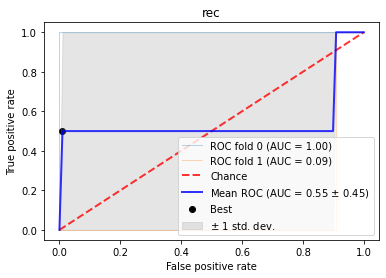

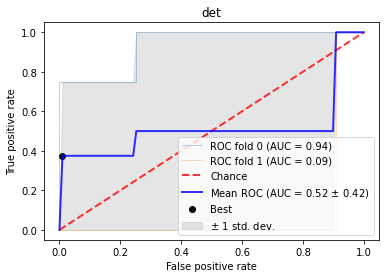

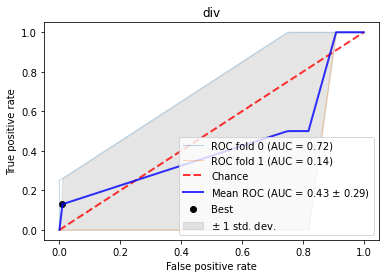

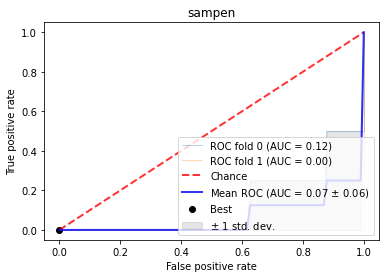

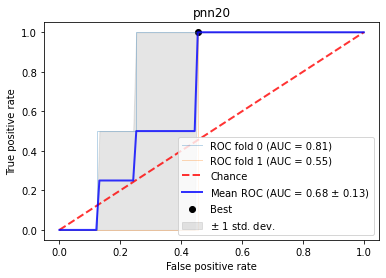

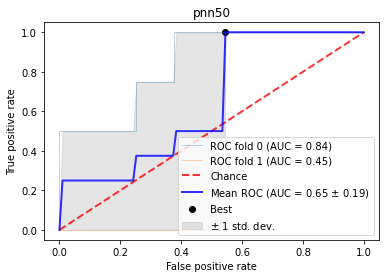

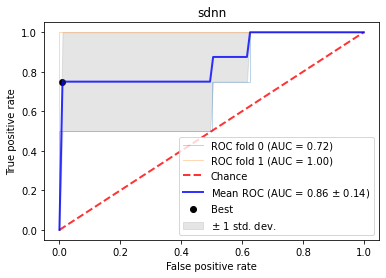

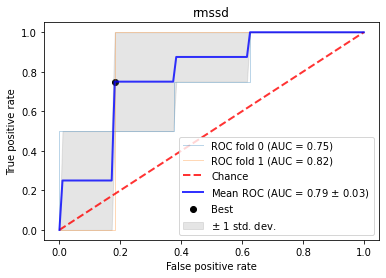

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from lib import plot_mean_roc

ss = ShuffleSplit(n_splits=n_folds, test_size=0.3, random_state=0)
classifier = LogisticRegression(penalty='l2', fit_intercept=True, random_state=0)
sig_feat_idx = np.flatnonzero(mean_pnorm < 0.1)  # get which features are significant

for k, feat_name in enumerate(feat_names):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots()
    pt_preds = []
    pt_trues = []
    for i, (train, test) in enumerate(ss.split(X, y)):
        # for ROC plot
        X_var = X[:,k].reshape(-1, 1)
        classifier.fit(X_var[train], y[train])
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X_var[test],
            y[test],
            name="ROC fold {}".format(i),
            pos_label=0,
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        
        y_pred = classifier.predict_proba(X_var[test])
        y_pred = y_pred[:,0]
        fpr, tpr, thresholds = roc_curve(y[test], y_pred)

        
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_thr = np.interp(mean_fpr, viz.fpr, thresholds)
        interp_tpr[0] = 0.0
        
        J = interp_tpr - mean_fpr
        idx = np.argmax(J)
        opt_th = interp_thr[idx]
        
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        
    plt, sens, spec, opt_th = plot_mean_roc(fig, ax, tprs, aucs, mean_fpr, interp_thr, feat_name, feat_name)
    print("{}: Sensitivity: {:.3f}%, Specificity: {:.3f}%".format(feat_name, 100*sens, 100*spec))
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    